In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
orig_data = pd.read_csv("data/train_2008.csv")
data = orig_data.copy()

In [5]:
data_orig_cols = list(orig_data.columns) # original columns, with target PES1 on the end

# Feature Engineering

In [6]:
### Goal: segment intuitively important features; standardize yes/no questions to binary

# Segment HUFAMINC (family income)
data['low_fam_inc'] = data.HUFAMINC.apply(lambda x: x >= 1 and x <= 11).astype(int)
data['med_fam_inc'] = data.HUFAMINC.apply(lambda x: x >= 12 and x <= 14).astype(int)
data['high_fam_inc'] = data.HUFAMINC.apply(lambda x: x >= 15).astype(int)

# Segment HRNUMHOU (number of household members)
data['one_person_hh'] = (data.HRNUMHOU == 1).astype(int)
data['two_person_hh'] = (data.HRNUMHOU == 2).astype(int)
data['multi_person_hh'] = (data.HRNUMHOU > 2).astype(int)

# Segment HUBUS (business/farm owner?)
data['farm_bus_hh'] = (data.HUBUS == 1).astype(int)
data['non_farm_bus_hh'] = (data.HUBUS == 2).astype(int)

# Segment GEREG (region)
data['northeast'] = (data.GEREG == 1).astype(int)
data['midwest'] = (data.GEREG == 2).astype(int)
data['south'] = (data.GEREG == 3).astype(int)
data['west'] = (data.GEREG == 4).astype(int)

# Segment PEAGE (age)
data['too_young'] = data.PEAGE.apply(lambda x: x >= 0 and x < 18).astype(int)
data['youth'] = data.PEAGE.apply(lambda x: x >= 18 and x < 40).astype(int)
data['middle_age'] = data.PEAGE.apply(lambda x: x >= 40 and x < 65).astype(int)
data['elderly'] = data.PEAGE.apply(lambda x: x >= 65).astype(int)

# Segment PEEDUCA (highest level of school completed or degree received)
data['hs_dropout'] = data.PEEDUCA.apply(lambda x: x < 39).astype(int)
data['hs_grad'] = data.PEEDUCA.apply(lambda x: x >= 39).astype(int)
data['bachelor_deg'] = data.PEEDUCA.apply(lambda x: x >= 43).astype(int)
data['adv_deg'] = data.PEEDUCA.apply(lambda x: x >= 44).astype(int)

# Segment PTDTRACE (race)
data['white_race'] = data.PTDTRACE.apply(lambda x: x == 1).astype(int)
data['black_race'] = data.PTDTRACE.apply(lambda x: x == 2).astype(int)
data['asian_race'] = data.PTDTRACE.apply(lambda x: x == 4).astype(int)
data['mixed_race'] = data.PTDTRACE.apply(lambda x: x >= 6).astype(int)

# Segment PENATVTY (country of birth)
data['us_born'] = data.PENATVTY.apply(lambda x: x == 57).astype(int)
data['us_territory_born'] = data.PENATVTY.apply(lambda x: x in [66, 73, 78, 96]).astype(int)
data['born_outside_us'] = data.PENATVTY.apply(lambda x: x == 555).astype(int)

# Segment PRINUSYR (immigrant entry year)
data['imm_last_10'] = data.PRINUSYR.apply(lambda x: x >= 16).astype(int)
data['imm_last_20'] = data.PRINUSYR.apply(lambda x: x >= 11 and x < 16).astype(int)
data['imm_before_1988'] = data.PRINUSYR.apply(lambda x: x >= 1 and x < 11).astype(int)

# Segment PUABSOT (did you have a job last week?)
data['employed'] = data.PUABSOT.apply(lambda x: x == 1).astype(int)
data['unemployed'] = data.PUABSOT.apply(lambda x: x == 2).astype(int) # This does not include retired; only unemployed

# Segment PEIO1COW (employer type)
data['fed_employed'] = data.PEIO1COW.apply(lambda x: x in [1, 2, 3]).astype(int)
data['priv_employed'] = data.PEIO1COW.apply(lambda x: x in [4, 5]).astype(int)
data['self_employed'] = data.PEIO1COW.apply(lambda x: x in [6, 7]).astype(int)

# Segment PRCHLD (has own children)
data['parent'] = data.PRCHLD.apply(lambda x: x >= 1).astype(int)

# Segment PEAFWHN1 (military service period)
data['ww2_vet'] = data.PEAFWHN1.apply(lambda x: x == 8).astype(int)
data['vietnam_vet'] = data.PEAFWHN1.apply(lambda x: x == 4).astype(int)
data['korea_vet'] = data.PEAFWHN1.apply(lambda x: x == 6).astype(int)

# 0/1 PESEX (sex)
data['male'] = data.PESEX.apply(lambda x: x == 1).astype(int)
data['female'] = data.PESEX.apply(lambda x: x == 2).astype(int)

# 0/1 PEHSPNON (hispanic?)
data['hispanic'] = data.PEHSPNON.apply(lambda x: x == 1).astype(int)
data['nonhispanic'] = data.PEHSPNON.apply(lambda x: x == 2).astype(int)

# 0/1 PURETOT (retired?)
data['retired'] = data.PURETOT.apply(lambda x: x == 1).astype(int)
data['not_retired'] = data.PURETOT.apply(lambda x: x >= 2).astype(int) # 3 indicates they just retired; treat as not retired

# 0/1 PEGRPROF (any grad/prof school courses for credit since bachelor's?)
data['grad_courses_since_bach'] = data.PEGRPROF.apply(lambda x: x == 1).astype(int)
data['no_grad_courses_since_bach'] = data.PEGRPROF.apply(lambda x: x == 2).astype(int)

# Drop allocation flag features; handle missing values

In [7]:
# Drop allocation flag features
allocation_flag_feats = [col for col in data.columns if col[:2] == 'PX']
data.drop(allocation_flag_feats, axis=1, inplace=True)

# Replace negative values (all forms of N/A) with NaN
for feat in data.columns:
    data[feat] = data[feat].apply(lambda x: np.NaN if x < 0 else x)
    
# Replace NaN with the mean of the column
for feat in data.columns:
    data[feat].fillna(data[feat].mean(), inplace=True)
    
# Check for columns that are all NaN, and delete them
all_nan_cols = []
for feat in data.columns:
    if np.all(np.isnan(data[feat])):
        all_nan_cols.append(feat)
data.drop(all_nan_cols, axis=1, inplace=True)

In [8]:
pes1 = data['PES1']
data.drop('PES1', axis=1, inplace=True)
data['PES1'] = pes1

In [9]:
data.columns

Index(['id', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HUSPNISH',
       'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL',
       ...
       'korea_vet', 'male', 'female', 'hispanic', 'nonhispanic', 'retired',
       'not_retired', 'grad_courses_since_bach', 'no_grad_courses_since_bach',
       'PES1'],
      dtype='object', length=326)

# Write out datasets

In [10]:
# Move PES1 (target feature) to the end of the dataframe
pes1 = data['PES1']
data.drop('PES1', axis=1, inplace=True)
data['PES1'] = pes1

# Make a dataframe of just the engineered features
data_eng_feats_only = data[data.columns[-48:]]



In [11]:
non_eng_feats = [col for col in data.columns if col.isupper()]

# Make a dataframe with no engineered features, just dropped allocation flags and NaNs removed
data_orig_clean = data[['id'] + non_eng_feats]

In [12]:
# Check that columns look right before writing out
data.columns

Index(['id', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HUSPNISH',
       'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL',
       ...
       'korea_vet', 'male', 'female', 'hispanic', 'nonhispanic', 'retired',
       'not_retired', 'grad_courses_since_bach', 'no_grad_courses_since_bach',
       'PES1'],
      dtype='object', length=326)

In [13]:
# Same for the eng-feats-only dataframe
data_eng_feats_only.columns

Index(['low_fam_inc', 'med_fam_inc', 'high_fam_inc', 'one_person_hh',
       'two_person_hh', 'multi_person_hh', 'farm_bus_hh', 'non_farm_bus_hh',
       'northeast', 'midwest', 'south', 'west', 'too_young', 'youth',
       'middle_age', 'elderly', 'hs_dropout', 'hs_grad', 'bachelor_deg',
       'adv_deg', 'white_race', 'black_race', 'asian_race', 'mixed_race',
       'us_born', 'us_territory_born', 'born_outside_us', 'imm_last_10',
       'imm_last_20', 'imm_before_1988', 'employed', 'unemployed',
       'fed_employed', 'priv_employed', 'self_employed', 'parent', 'ww2_vet',
       'vietnam_vet', 'korea_vet', 'male', 'female', 'hispanic', 'nonhispanic',
       'retired', 'not_retired', 'grad_courses_since_bach',
       'no_grad_courses_since_bach', 'PES1'],
      dtype='object')

In [14]:
# Same for the eng-feats-only dataframe
data_orig_clean.columns

Index(['id', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HUSPNISH',
       'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL',
       ...
       'PEMOMTYP', 'PECOHAB', 'PEDISEAR', 'PEDISEYE', 'PEDISREM', 'PEDISPHY',
       'PEDISDRS', 'PEDISOUT', 'PRDISFLG', 'PES1'],
      dtype='object', length=279)

In [189]:
# Write out new data sets
data_eng_feats_only.to_csv('train_2008_eng_feats_only.csv', index=False)
data.to_csv('train_2008_with_eng_feats_no_allo_flags.csv', index=False)
data_orig_clean.to_csv('train_2008_clean_no_eng_feats.csv', index=False)

# Remove misleading features (mostly codes)

starting with data that has engineered features, negative values set to the mean of the feature, and allocation flags removed.

In [15]:
# first list is from eyeballing; second is list of "weight" features that are just used for statistical tallying
bad_cols = ['QSTNUM', 'GESTFIPS', 'GESTCEN', 'HRMIS', 'GTCBSA'] + [col for col in data.columns if col[-3:] == 'WGT']

# drop 'em
data.drop(bad_cols, axis=1, inplace=True)

In [16]:
### GTCBSASZ indicates size of city of residence - seems useful. Let's dummy it!

# First we need to convert the codes into categorical variables
city_size_map = {
                    0:  'rural',
                    2:  '100_250',
                    3:  '250_500',
                    4:  '500_1000',
                    5:  '1000_2500',
                    6:  '2500_5000',
                    7:  '5000_plus'
                }
data['GTCBSASZ'] = data['GTCBSASZ'].map(city_size_map)

# encode in dummy vars
city_size_dummies = pd.get_dummies(data['GTCBSASZ'], prefix='city_size')

# add these new features to the data
data = pd.concat([data, city_size_dummies], axis=1)

In [17]:
# Drop the original city size feature
data.drop('GTCBSASZ', axis=1, inplace=True)

# Rearrange columns so the target PES1 is last
pes1 = data['PES1']
data.drop('PES1', axis=1, inplace=True)
data['PES1'] = pes1

In [18]:
data.columns

Index(['id', 'HRMONTH', 'HRYEAR4', 'HURESPLI', 'HUFINAL', 'HUSPNISH',
       'HETENURE', 'HEHOUSUT', 'HETELHHD', 'HETELAVL',
       ...
       'grad_courses_since_bach', 'no_grad_courses_since_bach',
       'city_size_1000_2500', 'city_size_100_250', 'city_size_2500_5000',
       'city_size_250_500', 'city_size_5000_plus', 'city_size_500_1000',
       'city_size_rural', 'PES1'],
      dtype='object', length=320)

# More exploration

In [19]:
train = data.ix[1:, 3:-1]
targets = data.ix[1:, -1].apply(lambda x: 0 if x == 2 else 1) # map to binary

In [20]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(train, targets)

In [21]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_

In [22]:
features.sort(['importance'],ascending=False).head(30)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,feature,importance
37,PEEDUCA,0.020741
30,PEAGE,0.020550
8,HUFAMINC,0.018464
280,bachelor_deg,0.014972
279,hs_grad,0.014571
3,HETENURE,0.013642
278,hs_dropout,0.013550
24,GTCBSAST,0.012096
23,GTCO,0.011658
16,HRHHID2,0.011622


In [23]:
train.shape

(64666, 316)

In [24]:
model = SelectFromModel(clf, prefit=True)
train_new = model.transform(train)
train_new.shape

(64666, 109)

In [25]:
train_new.shape

(64666, 109)

In [26]:
train_new = pd.DataFrame(train_new)
train_new['Y'] = np.array(targets)
train_new.to_csv('data/training_data_cleaned_for_2012_sub.csv', index=False)

In [27]:
train_new.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       100, 101, 102, 103, 104, 105, 106, 107, 108, 'Y'],
      dtype='object', length=110)

In [28]:
len(features)

316

In [141]:
train_new

array([[   1.,  201.,    2., ...,    0.,    0.,    0.],
       [   1.,    1.,    1., ...,    0.,    0.,    0.],
       [   2.,    1.,    1., ...,    0.,    0.,    1.],
       ..., 
       [   1.,    1.,    1., ...,    0.,    0.,    0.],
       [   1.,  201.,    3., ...,    0.,    1.,    0.],
       [   1.,  201.,    1., ...,    0.,    0.,    1.]])

In [29]:
imp_mean = features.importance.mean()

In [149]:
features[features['feature'] == 'south']['importance']

272    0.008672
Name: importance, dtype: float64

In [30]:
keep_feats = []
for f in features['feature']:
    if float(features[features['feature'] == f]['importance']) >= imp_mean:
        keep_feats.append(f)

In [35]:
len(train_new.columns)

110

In [31]:
len(keep_feats)

109

In [32]:
import pickle as pkl
pkl.dump(keep_feats, open('keep_feats.pkl', 'wb'))

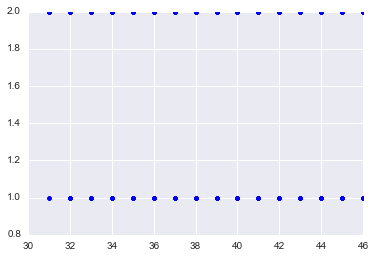

In [161]:
plt.plot(data['PEEDUCA'], data['PES1'], 'b.')

([array([    29.,      0.,     92.,      0.,    218.,      0.,    593.,
              0.,    408.,      0.,    619.,      0.,    857.,      0.,
            355.,      0.,  13232.,      0.,  10077.,      0.,   2277.,
              0.,   2711.,      0.,  10833.,      0.,   4237.,      0.,
            933.,    681.]),
  array([   110.,      0.,    214.,      0.,    457.,      0.,   1220.,
              0.,    890.,      0.,   1364.,      0.,   1817.,      0.,
            695.,      0.,  20202.,      0.,  13089.,      0.,   2867.,
              0.,   3270.,      0.,  12169.,      0.,   4559.,      0.,
           1013.,    731.])],
 array([ 31. ,  31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,
         35.5,  36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,
         40. ,  40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,
         44.5,  45. ,  45.5,  46. ]),
 <a list of 2 Lists of Patches objects>)

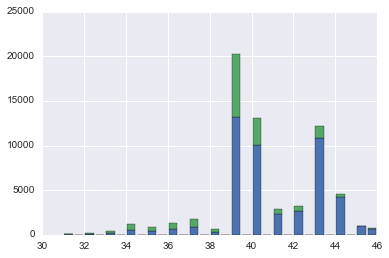

In [166]:
plt.hist([data[data['PES1'] == 1]['PEEDUCA'], data[data['PES1'] == 2]['PEEDUCA']], stacked=True, bins=30)

In [168]:
data['PEEDUCA'].median()

40.0